<a href="https://www.kaggle.com/code/barborakudlov/nlp-disastertweets-lstm-acc-0-98-val-acc-0-97?scriptVersionId=119894427" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [319]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


## Import the Necessary Libraries

In [320]:
#For modelling NLP
import tensorflow as tf 
import tensorflow_hub as hub

In [321]:
#For cleaning
import spacy 
import nltk 
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords 
import regex as re 
import string 

#For visualizing
import matplotlib.pyplot as plt 
import seaborn as sns 
pd.set_option('display.max_colwidth', None)

#For modelling NLP
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding
from tensorflow.keras.models import Sequential

## Import the Data

In [322]:
train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')

test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

ids = test.id

In [323]:
print('shape of training set: ', train.shape)
print('shape of testing set: ', test.shape)

shape of training set:  (7613, 5)
shape of testing set:  (3263, 4)


# Data Analysing- Missing values

In [324]:
#Concatenating the traind and test data
df_concat = pd.concat([train, test], axis=0).reset_index(drop=True)

nulls = pd.DataFrame(np.c_[df_concat.isnull().sum(), (df_concat.isnull().sum()/len(df_concat))*100], 
                     columns=['# of nulls', '% of nulls'], 
                     index=df_concat.columns)

nulls

,# of nulls,% of nulls
id,0.0,0.000000
keyword,87.0,0.799926
location,3638.0,33.449798
text,0.0,0.000000
target,3263.0,30.001839


In [325]:
for df in [train, test, df_concat]:
    df['keyword'].fillna('no_keyword', inplace=True)
    df['location'].fillna('no_location', inplace=True)

In [326]:
df_concat.groupby('location')['text'].count().sort_values(ascending=False)

location
no_location         3638
USA                  141
New York             109
United States         65
London                58
                    ... 
IG/SC:bjfordiani       1
IG: 94fijiwater        1
IG: AyshBanaysh        1
IG: xbougiebri         1
åø\_(?)_/åø            1
Name: text, Length: 4522, dtype: int64

# Visualizing the data keywords

- keywords have really important impact on if tweet is reporting disasters or non-disasters event

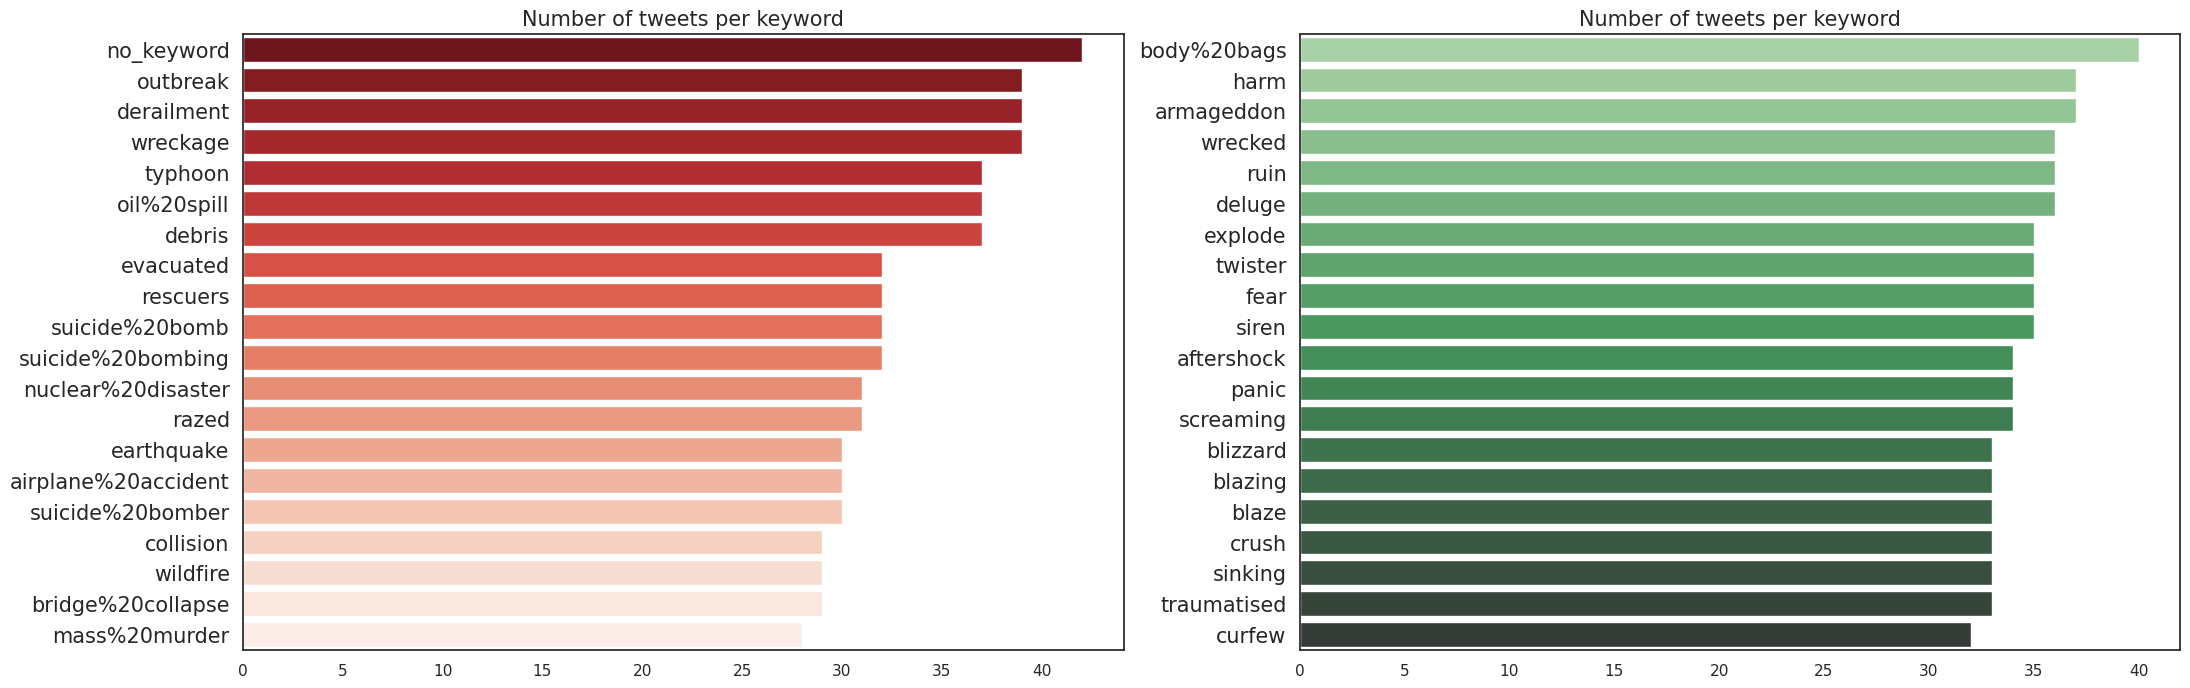

In [327]:
#seperation of disasters and non-disasters tweets and group them by this keywords, what are the most repeated
count_dis_keywords = train[train['target'] == 1].groupby('keyword').count().sort_values(by='target', ascending=False)[:20]

count_non_dis_keywords = train[train['target'] == 0].groupby('keyword').count().sort_values(by='target', ascending=False)[:20]

sns.set(style="white")

fig, axs = plt.subplots(1, 2, figsize=(25, 8))

#left plot- disasters keywords
sns.barplot(x=count_dis_keywords['target'], 
            y=count_dis_keywords.index,
            ax=axs[0],
            palette='Reds_r',
            label='dis')

#right plot- non-disasters keywords
sns.barplot(x=count_non_dis_keywords['target'], 
            y=count_non_dis_keywords.index,
            ax=axs[1],
            palette='Greens_d',
            label='non_dis')

for ax in [axs[0], axs[1]]:
    ax.set_title('Number of tweets per keyword', fontsize=15)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_yticklabels(labels=ax.get_yticklabels(), fontsize=15)

- we can see from red left plot, that a lot of disasters tweets do not have any keywords ()
- we can see from green green plot, that a data arent cleaned because of body%20bags so it will be the next step to classify the text as best as we can

In [328]:
#dropping the columns with a lot of NaN values
for df in [train, test, df_concat]:
    df.drop(columns=['location', 'keyword', 'id'], inplace=True)

# NLP Pipeline- Normalization(cleaning)

In [329]:
#for cleaning we will use 2 libraries- NLTK and SpaCy and in the end, we will choose the best one from these two ith the best result
nlp = spacy.load('en_core_web_sm')
sp = spacy.load('en_core_web_sm')

nltk.download('stopwords')
nltk.download('punkt')

spacy_st = nlp.Defaults.stop_words
nltk_st = stopwords.words('english')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [330]:
def clean1(tweet, http=True, punc=True, lem=True, stop_w=True):
    
    #substituion all the parts of the text, that has this formats 
    if http == True:
        tweet = re.sub('https?:\/\/t.co\/[A-Za-z0-9]*', '', tweet)
    
    #choose only one from NLTK or SpaCy with the best results
    if stop_w == 'nltk': #pokud stop_w=True
        tweet = [word for word in word_tokenize(tweet) if not word.lower() in nltk_st]
        tweet = ' '.join(tweet)
    
    #SpaCy has more stopwords around 400- so it can delete larger parts for my text, so that is the reason, that we will firstly use NLTK
    #pokud stop_w="spacy"
    elif stop_w == 'spacy':
        tweet = [word for word in word_tokenize(tweet) if not word.lower() in spacy_st]
        tweet = ' '.join(tweet)
      
    
    #lemmitizing
    if lem == True:
        lemmatized = [word.lemma_ for word in sp(tweet)] #lematizace z knihovny SpaCy
        tweet = ' '.join(lemmatized)
    
    #punctionation removal using translate- substitueting with blank space
    #Punctuation marks are symbols such as period (.), comma (,), semicolon (;), colon (:), question mark (?), exclamation mark (!), parentheses (), brackets [], braces {}, quotation marks "", apostrophe ('), and many others.
    if punc == True:
        tweet = tweet.translate(str.maketrans('', '', string.punctuation))
    
    #removing the extra space that may be around words or letters
    tweet = re.sub('\s+', ' ', tweet)
    
    return tweet

#lze zakomentovat, mužeme zkusit,v knihovně regex nejsou slovníky, má jenom seznam regular expressions
def clean2(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [331]:
df_concat['cleaned_text'] = df_concat['text'].apply(lambda x: clean1(x, lem=False, stop_w='nltk', http=True, punc=True)).apply(lambda x: clean2(x)) #This code will output the cleaned text for each tweet in the DataFrame (after clean1 and clean2)

# df_concat['cleaned_text'] = [nlp(text) for text in df_concat['cleaned_text']]

In [332]:
#split the train and test data back
cleaned_train = df_concat[:train.shape[0]] # So cleaned_train will contain the first train.shape[0] rows of df_concat, which are assumed to be the rows used for training a model.

cleaned_test = df_concat[train.shape[0]:]

cleaned_train.drop(columns=['text'], inplace=True)

cleaned_test.drop(columns=['text'], inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [333]:
cleaned_train

,target,cleaned_text
0,1.0,deeds reason earthquake may allah forgive us
1,1.0,forest fire near la ronge sask canada
2,1.0,residents asked shelter place notified officers evacuation shelter place orders expected
3,1.0,13000 people receive wildfires evacuation orders california
4,1.0,got sent photo ruby alaska smoke wildfires pours school
...,...,...
7608,1.0,two giant cranes holding bridge collapse nearby homes
7609,1.0,ariaahrary thetawniest control wild fires california even northern part state troubling
7610,1.0,m194 0104 utc 5km volcano hawaii
7611,1.0,police investigating ebike collided car little portugal ebike rider suffered serious nonlife threatening injuries


In [334]:
X_total = df_concat['cleaned_text']

X_train = cleaned_train['cleaned_text']
y_train = cleaned_train['target']

X_test = cleaned_test['cleaned_text']

In [335]:
"""
vectorizers = CountVectorizer(binary=True, 
                              ngram_range=(1, 3), 
                              stop_words='english') #pouze sčítá frekvenci výskytu jedn. slov v corpusu-tweety, ale není tolik dobrý, zejména pokud v našem dokuemntu jsou více specifické slova a nebo slov hodně

X_total_vectors = vectorizers.fit_transform(X_total)

print(vectorizers.get_feature_names_out())

print(X_total_vectors.toarray())

"""

"\nvectorizers = CountVectorizer(binary=True, \n                              ngram_range=(1, 3), \n                              stop_words='english') #pouze sčítá frekvenci výskytu jedn. slov v corpusu-tweety, ale není tolik dobrý, zejména pokud v našem dokuemntu jsou více specifické slova a nebo slov hodně\n\nX_total_vectors = vectorizers.fit_transform(X_total)\n\nprint(vectorizers.get_feature_names_out())\n\nprint(X_total_vectors.toarray())\n\n"

# Word Embeddings

## Suport Vector Machine(SVM)

In [336]:
"""
from sklearn import svm # Support Vector Machine (SVM) classifier is being used to classify the text data

clf_svm = svm.SVC(kernel='linear')

X_train_vectors = vectorizers.transform(X_train)

clf_svm.fit(X_train_vectors, y_train)
"""

"\nfrom sklearn import svm # Support Vector Machine (SVM) classifier is being used to classify the text data\n\nclf_svm = svm.SVC(kernel='linear')\n\nX_train_vectors = vectorizers.transform(X_train)\n\nclf_svm.fit(X_train_vectors, y_train)\n"

In [337]:
"""
X_test_vectors = vectorizers.transform(X_test)

print(vectorizers.get_feature_names_out())

print(X_test_vectors.toarray())
"""

'\nX_test_vectors = vectorizers.transform(X_test)\n\nprint(vectorizers.get_feature_names_out())\n\nprint(X_test_vectors.toarray())\n'

In [338]:
# sub_sample = pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')

# sub_sample

In [339]:
# sub_sample['target'] = clf_svm.predict(X_test_vectors)

# sub_sample['target'] = sub_sample['target'].astype('int')

# sub_sample.to_csv('submission.csv', index=False)

In [340]:
# submission = pd.read_csv('/kaggle/working/submission.csv')

# submission

## Bidirectional LSTM

In [341]:
from tensorflow.keras.layers import TextVectorization #podobné jako CountVectorizer, vhodné pro BidirectionalLSTM

In [342]:
X_total = df_concat['cleaned_text']

X_train = cleaned_train['cleaned_text']
y_train = cleaned_train['target'].values

X_test = cleaned_test['cleaned_text']

In [343]:
cleaned_test

,target,cleaned_text
7613,NaN,happened terrible car crash
7614,NaN,heard earthquake different cities stay safe everyone
7615,NaN,forest fire spot pond geese fleeing across street save
7616,NaN,apocalypse lighting spokane wildfires
7617,NaN,typhoon soudelor kills 28 china taiwan
...,...,...
10871,NaN,earthquake safety los angeles ûò safety fasteners xrwn
10872,NaN,storm ri worse last hurricane city amp 3others hardest hit yard looks like bombed around 20000k still without power
10873,NaN,green line derailment chicago
10874,NaN,meg issues hazardous weather outlook hwo


In [344]:
X_test

7613                                                                                             happened terrible car crash
7614                                                                    heard earthquake different cities stay safe everyone
7615                                                                  forest fire spot pond geese fleeing across street save
7616                                                                                   apocalypse lighting spokane wildfires
7617                                                                                  typhoon soudelor kills 28 china taiwan
                                                                ...                                                         
10871                                                                 earthquake safety los angeles ûò safety fasteners xrwn
10872    storm ri worse last hurricane city amp 3others hardest hit yard looks like bombed around 20000k still without power


In [345]:
len(X_total), len(X_train), len(X_test)

(10876, 7613, 3263)

In [346]:
# Define for Embeddings layer as pre-processing layer for tokenization
MAX_FEATURES = 20000 #  20 000most frequent words in the input text data.

vectorizer = TextVectorization(max_tokens=MAX_FEATURES, 
                               output_sequence_length=200, 
                               output_mode='int') 

In [347]:
vectorizer.adapt(X_total.values) #vypisuje všechna slova, co se vyskytují v dokuemntu

vectorizer.get_vocabulary()[:20]

['',
 '[UNK]',
 's',
 'û',
 'nt',
 'amp',
 'like',
 'fire',
 'm',
 'get',
 'new',
 'via',
 'news',
 'people',
 'one',
 '2',
 'us',
 'would',
 'video',
 'emergency']

In [348]:
#object for training a model on the preprocessed text data, which can be passed directly to the fit() method of a TensorFlow Keras model
vectorizerd_text = vectorizer(X_train.values)

dataset = tf.data.Dataset.from_tensor_slices((vectorizerd_text, y_train))
dataset = dataset.cache() #metody pro dataset v TensoFlow
dataset = dataset.shuffle(160000)
dataset = dataset.batch(32) 
dataset = dataset.prefetch(8)

In [349]:
#metody pro dataset v TensoFlow třída dataset příprava dat pro model
batch_X, batch_y = dataset.as_numpy_iterator().next()

batch_X.shape, batch_y.shape

((32, 200), (32,))

In [350]:
len(dataset)

train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [351]:
len(train), len(val), len(test)

(166, 47, 23)

In [352]:
model = Sequential()

model.add(Embedding(MAX_FEATURES + 1, 64)) #na vstupu bere tokeny a vytváří vektorovou reprezentaci, pokud není Embedding vrstva, musí být vektorizováno
model.add(Bidirectional(LSTM(64, activation='tanh')))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

#model.compile(loss='BinaryCrossentropy', optimizer='Adam', metrics=['accuracy']) 
model.compile(loss='BinaryCrossentropy', optimizer='Adam', metrics=[Recall()])

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, None, 64)          1280064   
                                                                 
 bidirectional_8 (Bidirectio  (None, 128)              66048     
 nal)                                                            
                                                                 
 dense_40 (Dense)            (None, 128)               16512     
                                                                 
 dense_41 (Dense)            (None, 256)               33024     
                                                                 
 dense_42 (Dense)            (None, 128)               32896     
                                                                 
 dense_43 (Dense)            (None, 64)                8256      
                                                      

In [353]:
hist= model.fit(train, epochs=30, batch_size=32, validation_data=val)

Epoch 1/30
166/166 [==============================] - 7s 25ms/step - loss: 0.5564 - recall_5: 0.4357 - val_loss: 0.3444 - val_recall_5: 0.7888
Epoch 2/30
166/166 [==============================] - 4s 23ms/step - loss: 0.3310 - recall_5: 0.7951 - val_loss: 0.2301 - val_recall_5: 0.8197
Epoch 3/30
166/166 [==============================] - 4s 22ms/step - loss: 0.2309 - recall_5: 0.8767 - val_loss: 0.1893 - val_recall_5: 0.9550
Epoch 4/30
166/166 [==============================] - 3s 20ms/step - loss: 0.1561 - recall_5: 0.9229 - val_loss: 0.1182 - val_recall_5: 0.9586
Epoch 5/30
166/166 [==============================] - 4s 21ms/step - loss: 0.1237 - recall_5: 0.9463 - val_loss: 0.0849 - val_recall_5: 0.9692
Epoch 6/30
166/166 [==============================] - 3s 20ms/step - loss: 0.0778 - recall_5: 0.9661 - val_loss: 0.0587 - val_recall_5: 0.9761
Epoch 7/30
166/166 [==============================] - 4s 21ms/step - loss: 0.0709 - recall_5: 0.9674 - val_loss: 0.0582 - val_recall_5: 0.9635

<Figure size 800x500 with 0 Axes>

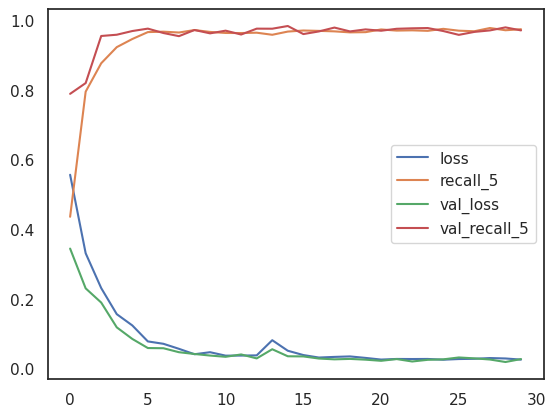

In [354]:
plt.figure(figsize=(8, 5))

pd.DataFrame(hist.history).plot()

plt.show()

In [355]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy
#from scikitlearn 

In [356]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy() #noname metrika

def output(num):
    if num <= 0.5:
        return 0
    else: 
        return 1
    

for batch in test.as_numpy_iterator():
    
    X_true, y_true = batch
    
    y_batchout = []
    
    yhat = model.predict(X_true)
    
    for num in yhat:
        y_batchout.append(output(num))
    
#     y_true = y_true.flatten()
#     yout = yout.flatten()
    
    print(y_true), print(y_batchout)
    
    pre.update_state(y_true, y_batchout)
    re.update_state(y_true, y_batchout)
    acc.update_state(y_true, y_batchout)

print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}')

1/1 [==============================] - 1s 852ms/step
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0.
 1. 1. 1. 0. 0. 0. 0. 1.]
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1]
1/1 [==============================] - 0s 19ms/step
[1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 1. 1. 1. 0. 1. 1. 0. 1.]
[0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1]
1/1 [==============================] - 0s 19ms/step
[0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0.
 1. 0. 0. 1. 0. 0. 0. 0.]
[0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0]
1/1 [==============================] - 0s 18ms/step
[1. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
[1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
1/1 [==

In [357]:
vectorizerd_test_text = vectorizer(X_test.values)

# testset = tf.data.Dataset.from_tensor_slices((vectorizerd_test_text))
# testset = dataset.cache()
# testset = dataset.shuffle(160000)
# testset = dataset.batch(8) 
# testset = dataset.prefetch(8)

In [ ]:
preds = []

for input_text in vectorizerd_test_text:
    
    pred = model.predict(np.expand_dims(input_text, 0))
    
    preds.append(pred)

1/1 [==============================] - 0s 22ms/step


In [ ]:
# preds

In [ ]:
final_preds = []

for pred in preds:
    
    final_preds.append(output(pred))

len(final_preds)

In [ ]:
sub_sample = pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')

sub_sample

In [ ]:
sub_sample['target'] = final_preds

sub_sample['target'] = sub_sample['target'].astype('int')

sub_sample.to_csv('submission.csv', index=False)

In [ ]:
submission = pd.read_csv('/kaggle/working/submission.csv')

submission

# End